(binary_hgf)=
# The binary Hierarchical Gaussian Filter

In [1]:
import jax.numpy as jnp
from ghgf.model import HGF
from ghgf import load_data
import seaborn as sns
import matplotlib.pyplot as plt

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In this notebook, we demonstrate how to create and fit the standard 2-levels and 3-level Hierarchical Gaussian Filters (HGF) for binary inputs. This class share a lot of similarities with its continuous counterpart described in the [next tutorial](continuous_hgf). Here, the difference is that the input node accepts binary data. Binary responses are widely used in decision-making neuroscience, and standard reinforcement learning algorithms like Rescorla-Wagner are tailored to learn outcomes probability under such configuration. Here, by using a Hierarchical Gaussian Filter, we want to be able to learn from the evolution of higher-level volatility, and the parameters that are influencing the strength of the coupling between lower-level nodes with their parents (i.e. $\omega$, or the `evolution rate` of the 1rst and 2nd levels nodes). The binary version of the Hierarchical Gaussian Filter can take the following structures:

```{figure} ../images/binary.svg
---
name: binary-hgf
---
The 2-levels and 3-level Hierarchical Gaussian Filter for binary inputs. Note that the first level $X_{1}$ is a value parent for the binary input node $\mathcal{B}$, and has itself a value parent $X_{2}$. A volatility parent is only used in the context of a 3-level HGF. This is a specificity of the binary model.
```

In this example, we will use data from a decision-making task where the outcome probability was manipulated across time, and observe how the binary HGFs can track switches in response probabilities.

## Imports
We import a time series of binary responses from the decision task described in {cite:p}`2013:iglesias`.

In [2]:
timeserie = load_data("binary")

## Fitting the binary HGF with fixed parameters
### The 2-levels binary Hierarchical Gaussian Filter
#### Create the model

The node structure corresponding to the 2-levels and 3-levels Hierarchical Gaussian Filters are automatically generated from `model_type` and `n_levels` using the nodes parameters provided in the dictionaries. Here we are not performing any optimization so thoses parameters are fixed to reasonnable values.

```{note}
The response function used is the binary surprise at each time points(:py:func:``ghgf.response.binary_surprise`). In other words, at each time point the model try to update its hierarchy to minimize the discrepancy between the expected and real next binary observation. See also [this tutorial](custom_response_function) to see how to create custom response function.
```

In [3]:
two_levels_hgf = HGF(
    n_levels=2,
    model_type="binary",
    initial_mu={"1": .0, "2": .5},
    initial_pi={"1": .0, "2": 1e4},
    omega={"1": None, "2": -3.0},
    rho={"1": None, "2": 0.0},
    kappas={"1": None},
    eta0=0.0,
    eta1=1.0,
    pihat = jnp.inf,
)

Creating a binary Hierarchical Gaussian Filter with 2 levels.


This function create an instance of a HGF model automatically parametrized for a 2-levels binary structure, so we do not have to worry about creating the nodes structure ourself. This class also embed function to add new observations and plots results that we are going to use below.

#### Add data

In [4]:
# Provide new observations
two_levels_hgf = two_levels_hgf.input_data(input_data=timeserie)

Add 320 new binary observations.


#### Plot trajectories

A Hierarchical Gaussian Filter is acting as a Bayesian filter when presented new observation, and by running the update equation forward, we can observe the trajectories of the nodes parameters that are being updated after each new observation (i.e. the mean $\mu$ and the precision $\pi$). The `plot_trajectories` function automatically extract the relevant parameters given the model structure and will plot their evolution together with the input data.

array([<AxesSubplot: ylabel='$\\mu_2$'>, <AxesSubplot: ylabel='$\\mu_1$'>,
       <AxesSubplot: xlabel='Time', ylabel='Surprise'>], dtype=object)

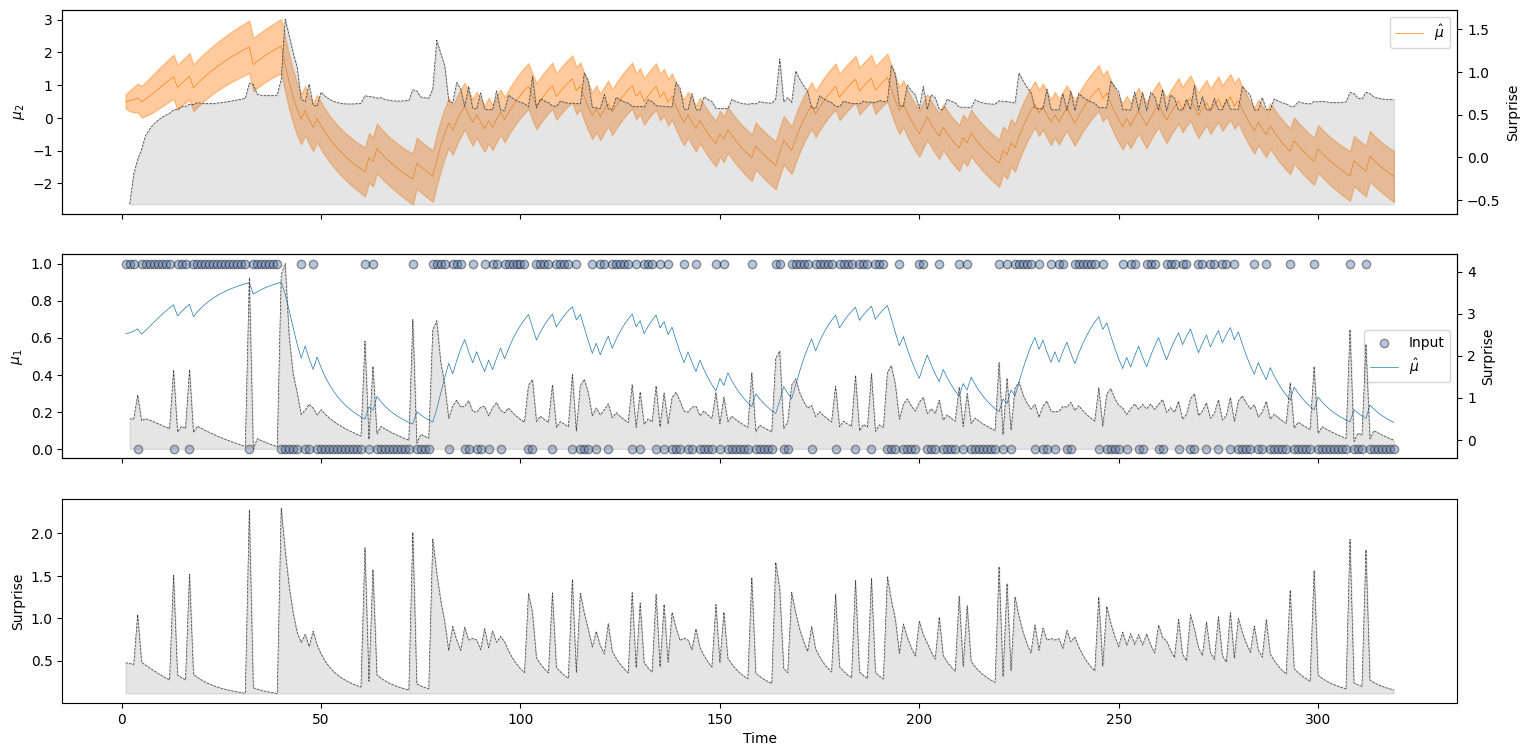

In [5]:
two_levels_hgf.plot_trajectories()

#### Surprise
We can see that the surprise will increase when the time series exhibit more unexpected behaviors. The degree to which a given observation is expected will deppends on the expeted value and volatility in the input node, that are influenced by the values of higher order nodes. One way to assess model fit is to look at the total binary surprise for each observation. This values can be returned from the fitted model using the `surprise` method:

In [6]:
two_levels_hgf.surprise()

Array(203.2925, dtype=float32)

```{note}
The surprise of a model under the observation of new data directly depends on the response function that was used. New response functions can be added and provided using different `response_function_parameters` and `response_function` in the py:func:`ghgf.model.HGF.surprise` method. The surprise is then defined as the negative log probability of new observations:

$$surprise = -log(p)$$
```

### The 3-levels binary Hierarchical Gaussian Filter
#### Create the model
Here, we create a new :py:`ghgf.model.HGF` instance, setting the number of levels to `3`. Note that we are extending the size of the dictionaries accordingly.

In [7]:
three_levels_hgf = HGF(
    n_levels=3,
    model_type="binary",
    initial_mu={"1": .0, "2": .5, "3": 0.},
    initial_pi={"1": .0, "2": 1e4, "3": 1e1},
    omega={"1": None, "2": -3.0, "3": -2.0},
    rho={"1": None, "2": 0.0, "3": 0.0},
    kappas={"1": None, "2": 1.0},
    eta0=0.0,
    eta1=1.0,
    pihat = jnp.inf,
)

Creating a binary Hierarchical Gaussian Filter with 3 levels.


#### Add data

In [8]:
three_levels_hgf = three_levels_hgf.input_data(input_data=timeserie)

Add 320 new binary observations.


#### Plot trajectories

array([<AxesSubplot: ylabel='$\\mu_3$'>, <AxesSubplot: ylabel='$\\mu_2$'>,
       <AxesSubplot: ylabel='$\\mu_1$'>,
       <AxesSubplot: xlabel='Time', ylabel='Surprise'>], dtype=object)

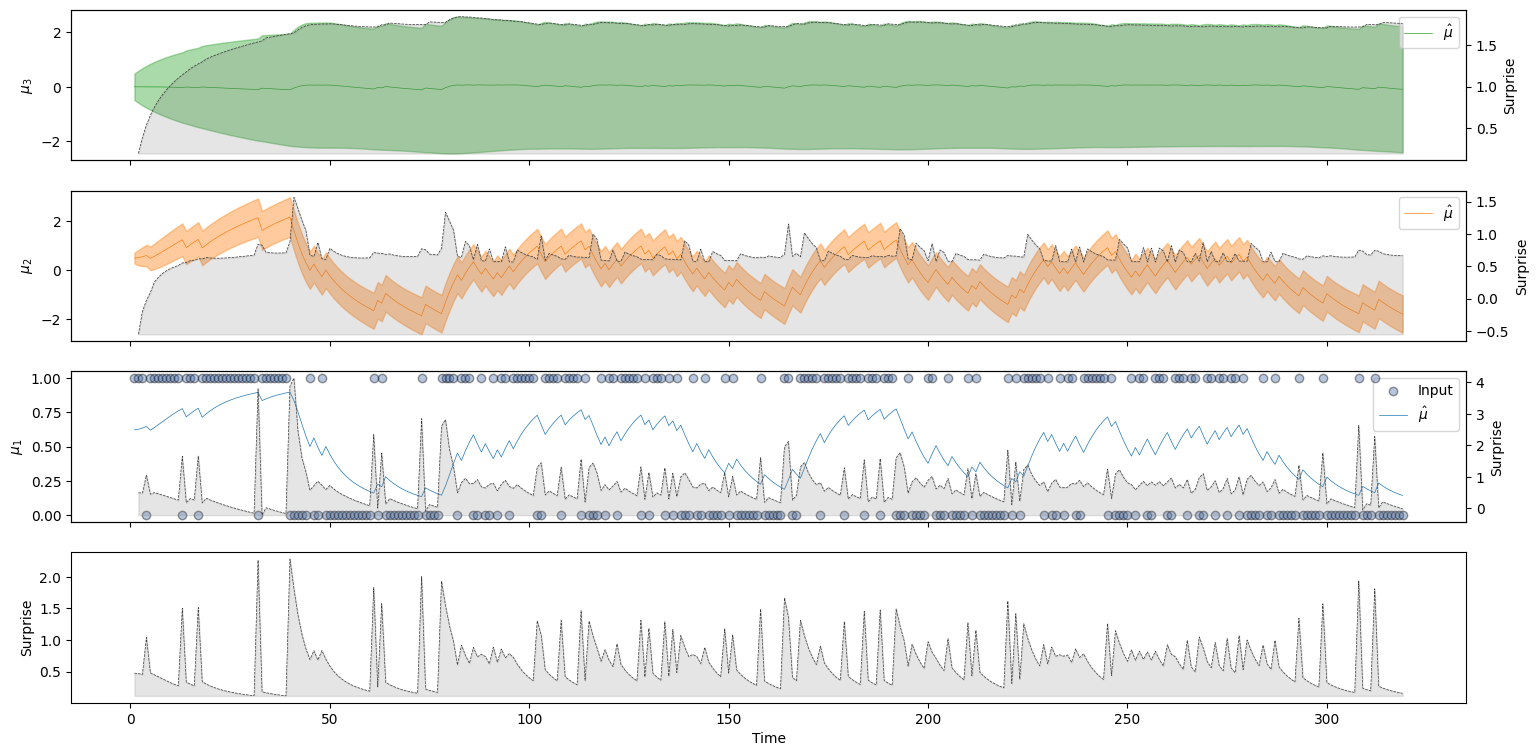

In [9]:
three_levels_hgf.plot_trajectories()

## Learning parameters with MCMC sampling
In the previous section, we assumed we knew the parameters of the HGF models that were used to filter the input data. This can give us information on how an agent using these values would behave when presented with these inputs. We can also adopt a different perspective and consider that we want to learn these parameters from the data. Here, we are going to set some of the parameters free and use Hamiltonian Monte Carlo methods (NUTS) to sample their probability density.

Because the HGF classes are built on the top of [JAX](https://github.com/google/jax), they are natively differentiable and compatible with optimisation libraries or can be embedded as regular distributions in the context of a Bayesian network. Here, we are using this approach, and we are going to use [PyMC](https://www.pymc.io/welcome.html) to perform this step. PyMC can use any log probability function (here the negative surprise of the model) as a building block for a new distribution by wrapping it in its underlying tensor library [Aesara](https://aesara.readthedocs.io/en/latest/), now forked as [PyTensor](https://pytensor.readthedocs.io/en/latest/). This PyMC-compatible distribution can be found in the :py:`ghgf.distribution` sub-module.

In [10]:
import pymc as pm
import arviz as az
from ghgf.distribution import HGFDistribution
from ghgf.response import total_binary_surprise

### 2-levels model
#### Creating the model

In [11]:
hgf_logp_op = HGFDistribution(
    n_levels=2,
    model_type="binary",
    input_data=[timeserie],
    response_function=total_binary_surprise,
)

```{note}
The data is being passed to the distribution when the instance is created.
```

In [12]:
with pm.Model() as two_levels_binary_hgf:

    omega_2 = pm.Uniform("omega_2", -3.5, 0.0)

    pm.Potential(
        "hgf_loglike",
        hgf_logp_op(
            omega_1=jnp.inf,
            omega_2=omega_2,
            omega_input=jnp.inf,
            rho_1=0.0,
            rho_2=0.0,
            pi_1=0.0,
            pi_2=1e4,
            mu_1=jnp.inf,
            mu_2=0.5,
            kappa_1=1.0,
            omega_3=jnp.nan,
            rho_3=jnp.nan,
            pi_3=jnp.nan,
            mu_3=jnp.nan,
            kappa_2=jnp.nan
        ),
    )

#### Visualizing the model

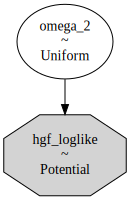

In [13]:
pm.model_to_graphviz(two_levels_binary_hgf)

#### Sampling

In [14]:
with two_levels_binary_hgf:
    two_level_hgf_idata = pm.sample(chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


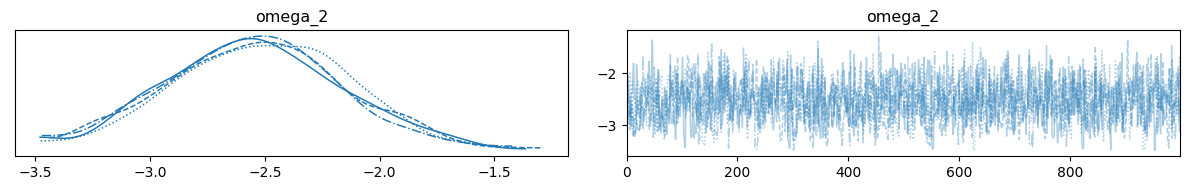

In [15]:
az.plot_trace(two_level_hgf_idata, var_names=["omega_2"]);
plt.tight_layout()

### Using the learned parameters
To visualize how the model would behave under the most probable values, we average the $\omega_{2}$ samples and use this value in a new model.

In [16]:
omega_2 = az.summary(two_level_hgf_idata)["mean"]["omega_2"]

In [17]:
hgf_mcmc = HGF(
    n_levels=2,
    model_type="binary",
    initial_mu={"1": jnp.inf, "2": 0.5},
    initial_pi={"1": 0.0, "2": 1e4},
    omega={"1": jnp.inf, "2": omega_2},
    omega_input=jnp.inf,
    rho={"1": 0.0, "2": 0.0},
    kappas={"1": 1.0}).input_data(
        input_data=timeserie
    )

Creating a binary Hierarchical Gaussian Filter with 2 levels.
Add 320 new binary observations.


array([<AxesSubplot: ylabel='$\\mu_2$'>, <AxesSubplot: ylabel='$\\mu_1$'>,
       <AxesSubplot: xlabel='Time', ylabel='Surprise'>], dtype=object)

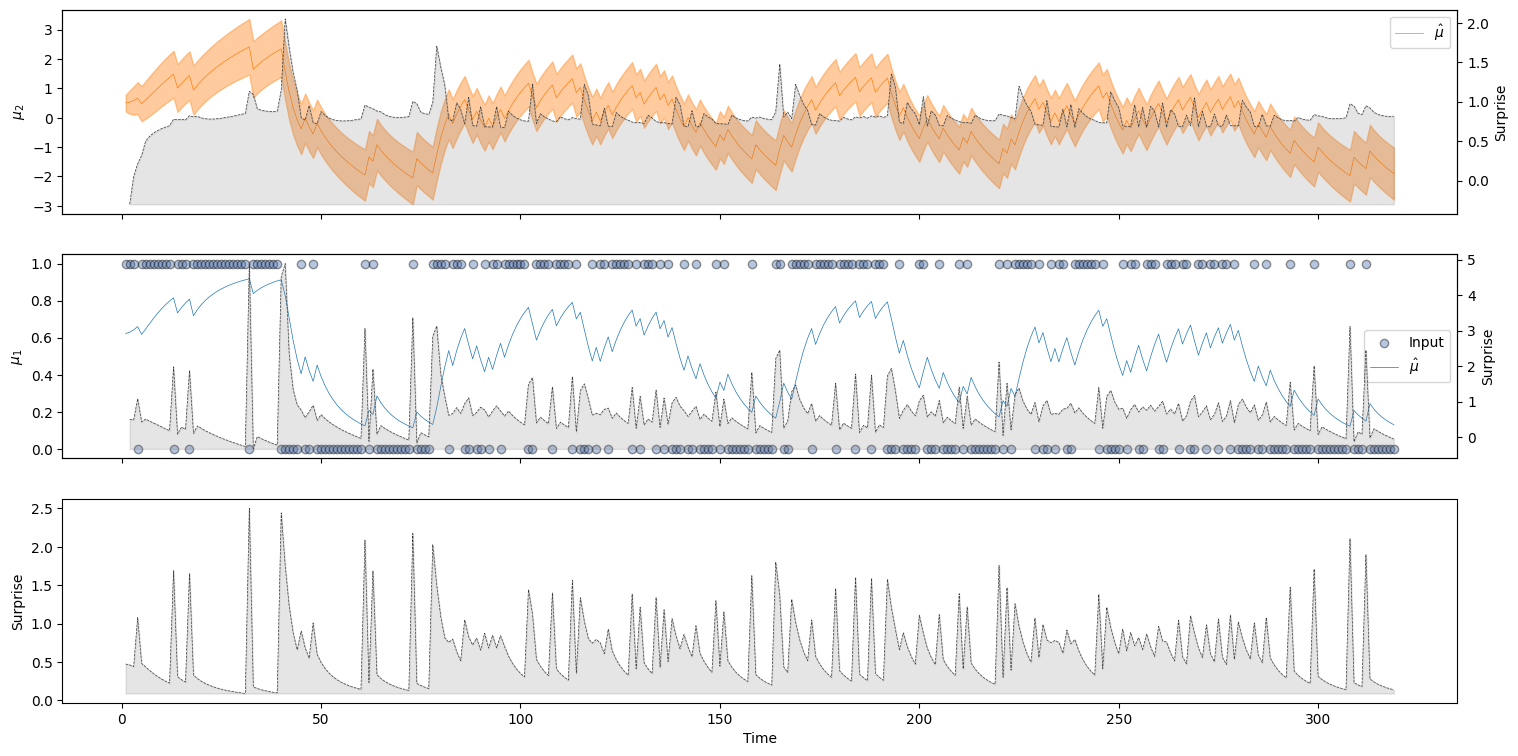

In [18]:
hgf_mcmc.plot_trajectories()

In [19]:
hgf_mcmc.surprise()

Array(202.64676, dtype=float32)

### 3-levels model
#### Creating the model

In [20]:
hgf_logp_op = HGFDistribution(
    n_levels=3,
    model_type="binary",
    input_data=[timeserie],
    response_function=total_binary_surprise,
)

```{note}
The data is being passed to the distribution when the instance is created.
```

In [21]:
with pm.Model() as three_levels_binary_hgf:

    omega_2 = pm.Uniform("omega_2", -4.0, 0.0)
    omega_3 = pm.Normal("omega_3", -11.0, 2)

    pm.Potential(
        "hgf_loglike",
        hgf_logp_op(
            omega_1=jnp.inf,
            omega_2=omega_2,
            omega_3=omega_3,
            omega_input=jnp.inf,
            rho_1=0.0,
            rho_2=0.0,
            rho_3=0.0,
            pi_1=0.0,
            pi_2=1e4,
            pi_3=1e1,
            mu_1=jnp.inf,
            mu_2=0.5,
            mu_3=0.0,
            kappa_1=1.0,
            kappa_2=1.0,
        ),
    )

#### Visualizing the model

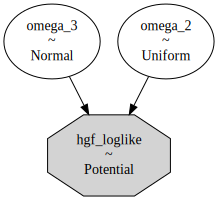

In [22]:
pm.model_to_graphviz(three_levels_binary_hgf)

#### Sampling

In [23]:
with three_levels_binary_hgf:
    three_level_hgf_idata = pm.sample(chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_2, omega_3]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


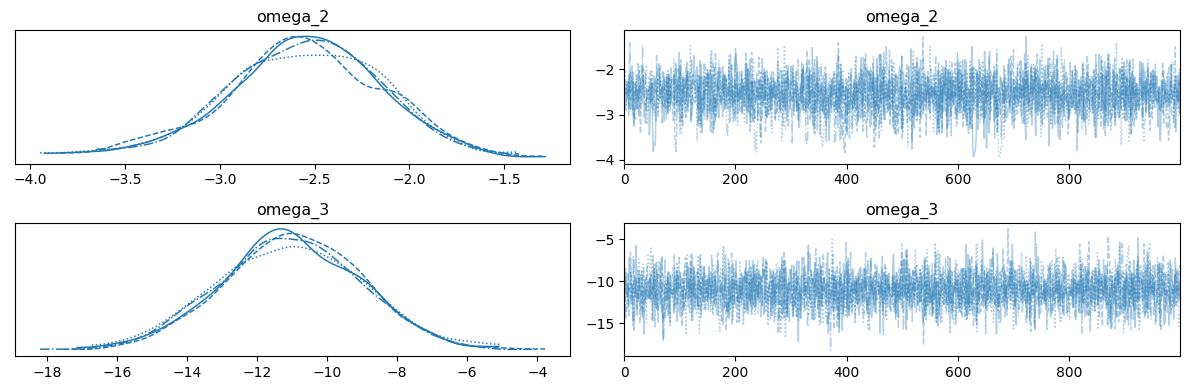

In [24]:
az.plot_trace(three_level_hgf_idata, var_names=["omega_2", "omega_3"]);
plt.tight_layout()

### Using the learned parameters
To visualize how the model would behave under the most probable values, we average the $\omega_{2}$ samples and use this value in a new model.

In [25]:
omega_2 = az.summary(three_level_hgf_idata)["mean"]["omega_2"]
omega_3 = az.summary(three_level_hgf_idata)["mean"]["omega_3"]

In [26]:
hgf_mcmc = HGF(
    n_levels=3,
    model_type="binary",
    initial_mu={"1": jnp.inf, "2": 0.5, "3": 0.0},
    initial_pi={"1": 0.0, "2": 1e4, "3": 1e1},
    omega={"1": jnp.inf, "2": omega_2, "3": omega_3},
    omega_input=jnp.inf,
    rho={"1": 0.0, "2": 0.0, "3": 0.0},
    kappas={"1": 1.0, "2": 1.0}).input_data(
        input_data=timeserie
    )

Creating a binary Hierarchical Gaussian Filter with 3 levels.
Add 320 new binary observations.


array([<AxesSubplot: ylabel='$\\mu_3$'>, <AxesSubplot: ylabel='$\\mu_2$'>,
       <AxesSubplot: ylabel='$\\mu_1$'>,
       <AxesSubplot: xlabel='Time', ylabel='Surprise'>], dtype=object)

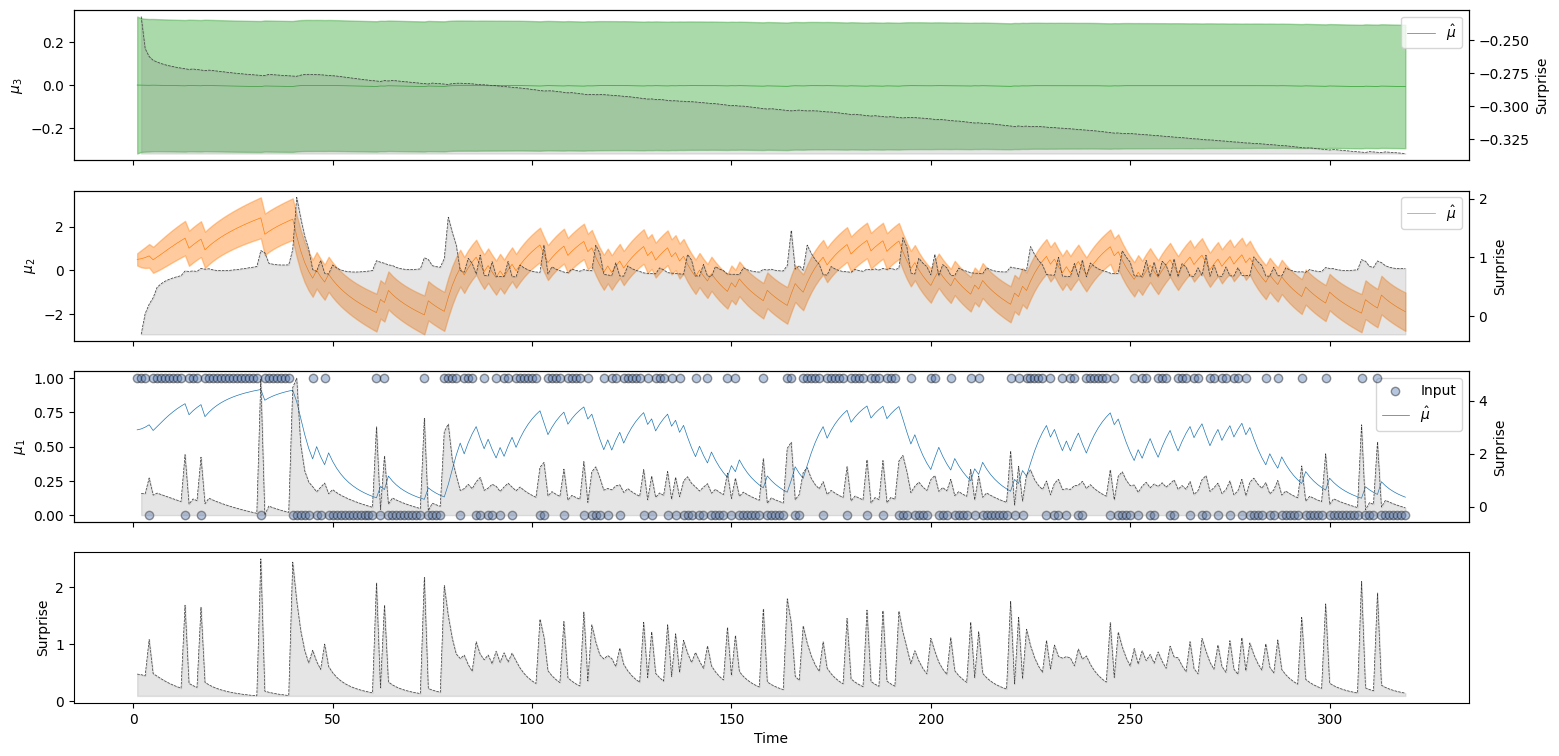

In [27]:
hgf_mcmc.plot_trajectories()

In [28]:
hgf_mcmc.surprise()

Array(202.65701, dtype=float32)

# System configuration

In [29]:
%load_ext watermark
%watermark -n -u -v -iv -w -p ghgf,jax,jaxlib

Last updated: Fri Feb 17 2023

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 8.4.0

ghgf  : 0.0.1dev
jax   : 0.4.1
jaxlib: 0.4.1

jax       : 0.4.1
matplotlib: 3.4.3
arviz     : 0.13.0
seaborn   : 0.12.1
pymc      : 5.0.2

Watermark: 2.3.1

